## Python set-up

In [1]:
# Lib imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
from datetime import datetime

# Local imports
from abs_data_capture import (
    AbsLandingPage,
    get_abs_data,
    create_selector_series_dataframe,
    create_all_series_dataframe,
    clear_cache,
    metacol
)

# Clearing cache data from 
clear_cache()

## Utility Functions

In [2]:
def annualise_rates(data: pd.Series, periods: int|float = 12) -> pd.Series:
    """Annualise a growth rate for a period."""
    return (((1 + data.pct_change(periods=1)) ** periods) - 1) * 100

def annualise_percentages(data: pd.Series, periods: int|float = 12) -> pd.Series:
    """Annualise a growth rate (expressed as a percentage) for a period."""
    rates = data / 100.0
    return annualise_rates(rates, periods)

def absolute_change(data: pd.Series, periods: int|float = 1) -> pd.Series:
    """Calculate an n-periods absolute change."""
    return data - data.shift(periods)

def percent_change(data: pd.Series, periods: int|float = 1) -> pd.Series:
    """Calculate an n-periods percentage change."""
    return (data / data.shift(periods) - 1) * 100

def create_index_series(series: pd.Series, base_date: str) -> pd.Series:
    """ Return a series with values adjusted by the index."""
    
    # Check if base_date is in the series index
    if base_date not in series.index:
        raise ValueError("base_date not found in the series index")

    # Calculate the index factor
    base_value = series.loc[base_date]
    if base_value == 0:
        raise ValueError("base_value at base_date is zero, cannot create index")

    indexed_series = (series / base_value) * 100
    return indexed_series

def custom_quarter_to_timestamp(index):
    """
    Convert a pandas PeriodIndex with quarterly periods (custom ending in FEB, MAY, AUG, NOV)
    to a DatetimeIndex where each quarter is represented by the actual end date.

    Parameters:
    - index: PeriodIndex in the format YYYYQX (where X is 1, 2, 3, 4)
    
    Returns:
    - A DatetimeIndex with correct end dates based on custom quarterly periods
    """
    month_mapper = {1: 2, 2: 5, 3: 8, 4: 11}  # Mapping quarter number to ending month
    dates = []

    for period in index:
        year = period.year
        quarter = period.quarter
        end_month = month_mapper[quarter]
        end_date = pd.Timestamp(year=year, month=end_month, day=1) + pd.offsets.MonthEnd(0)
        dates.append(end_date)

    return pd.DatetimeIndex(dates)

def compile_series_from_table(abs_dict, table_name, verbose=False):
    """
    Compila todas as séries de uma tabela especificada em um DataFrame.

    Arguments:
    - abs_dict: dict[str, DataFrame] - dicionário contendo DataFrames de dados e meta-dados da ABS.
    - table_name: str - nome da tabela de onde extrair as séries.
    - verbose: bool - se verdadeiro, exibe informações adicionais durante o processo.

    Returns:
    - DataFrame com cada série como uma coluna.
    """
    # Verifica se a tabela especificada está presente no dicionário
    if table_name not in abs_dict:
        raise ValueError("Specified table is not present in the dictionary")

    # DataFrame para coletar as séries
    series_df = pd.DataFrame()

    # Itera sobre cada série no DataFrame especificado
    for series_id in abs_dict[table_name].columns:
        # Obtém a descrição da série do DataFrame de metadados
        if verbose:
            print(f"Adding series ID {series_id} to DataFrame")
        description = abs_dict['META_DATA'].loc[abs_dict['META_DATA']['Series ID'] == series_id, 'Data Item Description'].values[0]

        # Adiciona a série ao DataFrame resultante, usando a descrição da série como nome da coluna
        series_df[description] = abs_dict[table_name][series_id]

    return series_df

## Get data from ABS

In [3]:
LANDING_PAGE_LABOUR_FORCE = AbsLandingPage(
    theme="labour",
    parent_topic="employment-and-unemployment",
    topic="labour-force-australia",
)

abs_dict_lf = get_abs_data(LANDING_PAGE_LABOUR_FORCE)

LANDING_PAGE_JOB_VACANCIES = AbsLandingPage(
    theme="labour",
    parent_topic="employment-and-unemployment",
    topic="job-vacancies-australia",
)

abs_dict_jv = get_abs_data(LANDING_PAGE_JOB_VACANCIES)

LANDING_PAGE_JOBS = AbsLandingPage(
    theme="labour", 
    parent_topic="labour-accounts", 
    topic="labour-account-australia"
)

abs_dict_jobs = get_abs_data(LANDING_PAGE_JOBS)

LANDING_PAGE_WPI = AbsLandingPage(
    theme="economy",
    parent_topic="price-indexes-and-inflation",
    topic="wage-price-index-australia",
)

abs_dict_wpi = get_abs_data(LANDING_PAGE_WPI)

## Getting Dataframe with ABS Info

In [39]:
labour_trend = {
        "1": metacol.table,
        "Persons": metacol.did,
        "Trend":metacol.stype
    }

labour_sa = {
        "1": metacol.table,
        "Persons": metacol.did,
        "Seasonally Adjusted":metacol.stype
    }

job_vacancy_sa = {
        "1": metacol.table,
        "Seasonally Adjusted": metacol.stype,
    }

job_vacancy_by_industry = {
        "4": metacol.table,
        "": metacol.did,
        "STOCK": metacol.dtype,
    }

underemployment_trend = {
        "22": metacol.table,
        "A85256589V": metacol.id,
    }

underemployment_sa = {
        "22": metacol.table,
        "A85255725J": metacol.id,
    }

jobs_vacancy_rate = {
    "1": metacol.table,
    "A85389541V": metacol.id,
}

wpi_ex_bonuses_yoy = {
    "1": metacol.table,
    "A83895396W": metacol.id,
}

hours_worked_sa = {
    "19": metacol.table,
    "Persons": metacol.did,
    "Seasonally Adjusted":metacol.stype,
}

hours_worked_trend = {
    "19": metacol.table,
    "Persons": metacol.did,
    "Trend":metacol.stype,
}

In [41]:
df_labour_trend = create_selector_series_dataframe(abs_dict_lf, labour_trend)
df_labour_sa = create_selector_series_dataframe(abs_dict_lf, labour_sa)
df_job_vacancy_sa = create_selector_series_dataframe(abs_dict_jv, job_vacancy_sa)
df_job_vacancy_by_industry = compile_series_from_table(abs_dict_jv,"4")
df_under_trend = create_selector_series_dataframe(abs_dict_lf,underemployment_trend)
df_under_sa = create_selector_series_dataframe(abs_dict_lf,underemployment_sa)
df_jv_rate_sa = create_selector_series_dataframe(abs_dict_jobs, jobs_vacancy_rate)
df_hour_worked_sa = create_selector_series_dataframe(abs_dict_lf, hours_worked_sa)
df_hour_worked_trend = create_selector_series_dataframe(abs_dict_lf, hours_worked_trend)
df_wpi_ex_bonus_yoy_sa = create_selector_series_dataframe(abs_dict_wpi, wpi_ex_bonuses_yoy)
df_labour_trend.index = df_labour_trend.index.to_timestamp()
df_labour_sa.index = df_labour_sa.index.to_timestamp()
df_under_trend.index = df_under_trend.index.to_timestamp()
df_under_sa.index = df_under_sa.index.to_timestamp()
df_job_vacancy_sa.index = custom_quarter_to_timestamp(df_job_vacancy_sa.index)
df_jv_rate_sa.index = df_jv_rate_sa.index.to_timestamp()
df_wpi_ex_bonus_yoy_sa.index = df_wpi_ex_bonus_yoy_sa.index.to_timestamp()
df_hour_worked_sa.index = df_hour_worked_sa.index.to_timestamp()
df_hour_worked_trend.index = df_hour_worked_trend.index.to_timestamp()


## Getting Plots for PDF

### Already Done

In [6]:
# Use a relative path for the PDF
pdf_path = 'Labour_Market_Report.pdf'
pdf = PdfPages(pdf_path)

In [7]:
# Figure 1: Labour Market Summary
# Creating the plot with specified dimensions
fig, ax1 = plt.subplots(figsize=(14, 8))

# Adding a page title above the plot
fig.suptitle('Figure 1: Labour Market, Summary', fontsize=16, fontweight='bold', y=0.95)

# Plotting unemployment rate with a red line
ax1.plot(df_labour_sa.index, df_labour_sa['Unemployment rate'], label='Unemployment Rate', color='tab:red')

# Plotting underemployment rate with a blue line
ax1.plot(df_under_sa.index, df_under_sa['Underemployment rate (proportion of labour force)'], label='Underemployment Rate (Proportion of Labour Force)', color='tab:blue')

# Creating a secondary y-axis for the participation rate
ax2 = ax1.twinx()
ax2.plot(df_labour_sa.index, df_labour_sa['Participation rate'], label='Participation Rate (RHS)', color='tab:green', linestyle='--')

# Setting x-axis and y-axis labels
ax1.set_xlabel('Date')
ax1.set_ylabel('(%)')
ax2.set_ylabel('(%)', color='tab:green')

# Setting a title for the axes
ax1.set_title('Australia Labour Market')

# Formatting the x-axis to show month/year and adjusting interval to display a tick every six months
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

# Setting x-axis limits to start from a specific date
ax1.set_xlim([datetime(2009, 10, 1), df_labour_sa.index.max()])

# Adding grid lines to the primary axis
ax1.grid(True)

# Rotating x-axis labels for better readability
plt.setp(ax1.get_xticklabels(), rotation=90)

# Adding legends for both primary and secondary y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjusting layout to ensure the plot is centered and fits well within an A4 page
plt.tight_layout(pad=2.0)

# Saving the current figure into the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()

In [8]:
# Figure 2: Labour Force Summary
fig, ax1 = plt.subplots(figsize=(14, 8))

# Add page title
fig.suptitle('Figure 2: Labour Force, Summary', fontsize=16, fontweight='bold', y=0.95)

# Plot total labour force and total employed
ax1.plot(df_labour_sa.index, df_labour_sa['Labour force total'], label='Labour Force Total', color='tab:blue')
ax1.plot(df_labour_sa.index, df_labour_sa['Employed total'], label='Employed Total', color='tab:green')

# Create a second y-axis for total unemployed
ax2 = ax1.twinx()
ax2.plot(df_labour_sa.index, df_labour_sa['Unemployed total'], label='Unemployed Total (RHS)', color='tab:red', linestyle='--')

# Set labels for x and y axes
ax1.set_xlabel('Date')
ax1.set_ylabel('(Thousands)')
ax2.set_ylabel('(Thousands)', color='tab:red')

# Set title for the axes
ax1.set_title('Labour Force')

# Format x-axis to show month/year
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

# Set x-axis limits
ax1.set_xlim([datetime(2009, 10, 1), df_labour_sa.index.max()])

# Add grid to the main axis
ax1.grid(True)

# Rotate x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=90)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout to ensure the plot is centered and well-fitted on the A4 page
plt.tight_layout(pad=2.0)

# Save the current figure to the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()


In [9]:
# Figure 3: Employment Growth
fig, ax1 = plt.subplots(figsize=(14, 8))

# Calculating series for plotting
total_employee_growth = percent_change(df_labour_sa['Employed total'], 12)
full_time_employee_growth = percent_change(df_labour_sa['> Employed full-time'], 12)
part_time_employee_growth = percent_change(df_labour_sa['> Employed part-time'], 12)

# Add page title
fig.suptitle('Figure 3: Employment Growth', fontsize=16, fontweight='bold', y=0.95)

# Plot lines
ax1.plot(total_employee_growth.index, total_employee_growth, label='Total', color='tab:red')
ax1.plot(full_time_employee_growth.index, full_time_employee_growth, label='Full-Time', color='tab:blue')
ax1.plot(part_time_employee_growth.index, part_time_employee_growth, label='Part-Time', color='tab:green')

# Set labels for x and y axes
ax1.set_xlabel('Date')
ax1.set_ylabel('(%)')

# Set title for the axes
ax1.set_title('Employment Growth (YoY)')

# Format x-axis to show month/year
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

# Set x-axis limits
ax1.set_xlim([datetime(2009, 10, 1), total_employee_growth.index.max()])

# Add grid to the main axis
ax1.grid(True)

# Rotate x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=90)

# Add legends
ax1.legend(loc='upper left')

# Adjust layout to ensure the plot is centered and well-fitted on the A4 page
plt.tight_layout(pad=2.0)

# Save the current figure to the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()

In [10]:
# Figure 4: Employment Change
fig, ax1 = plt.subplots(figsize=(14, 8))

# Calculating series for plotting
abs_total_employee_growth = absolute_change(df_labour_sa['Employed total'], 1)
abs_full_time_employee_growth = absolute_change(df_labour_sa['> Employed full-time'], 1)
abs_part_time_employee_growth = absolute_change(df_labour_sa['> Employed part-time'], 1)

# Add page title
fig.suptitle('Figure 4: Employment Change', fontsize=16, fontweight='bold', y=0.95)

# Plot lines
ax1.plot(abs_total_employee_growth.index, abs_total_employee_growth, label='Total', color='tab:red')
ax1.bar(abs_full_time_employee_growth.index, abs_full_time_employee_growth, 25, label='Full-Time', color='tab:blue')
ax1.bar(abs_part_time_employee_growth.index, abs_part_time_employee_growth, 25, label='Part-Time', color='tab:green')

# Set labels for x and y axes
ax1.set_xlabel('Date')
ax1.set_ylabel('Changes')

# Set title for the axes
ax1.set_title('Employment Changes (MoM)')

# Format x-axis to show month/year
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

# Set x-axis limits
ax1.set_xlim([datetime(2009, 10, 1), abs_total_employee_growth.index.max()])

# Add grid to the main axis
ax1.grid(True)

# Rotate x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=90)

# Add legends
ax1.legend(loc='upper left')

# Adjust layout to ensure the plot is centered and well-fitted on the A4 page
plt.tight_layout(pad=2.0)

# Save the current figure to the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()

In [11]:
# Figure 5: Employment Comparision
fig, ax1 = plt.subplots(figsize=(14, 8))

# Calculating series for plotting
idx_total_employee = create_index_series(df_labour_sa['Employed total'], '2000-01-01')
idx_full_time_employee = create_index_series(df_labour_sa['> Employed full-time'], '2000-01-01')
idx_part_time_employee = create_index_series(df_labour_sa['> Employed part-time'], '2000-01-01')

# Add page title
fig.suptitle('Figure 5: Employment Comparision', fontsize=16, fontweight='bold', y=0.95)

# Plot lines
ax1.plot(idx_total_employee.index, idx_total_employee, label='Total', color='tab:red')
ax1.plot(idx_full_time_employee.index, idx_full_time_employee, label='Full-Time', color='tab:blue')
ax1.plot(idx_part_time_employee.index, idx_part_time_employee, label='Part-Time', color='tab:green')

# Set labels for x and y axes
ax1.set_xlabel('Date')
ax1.set_ylabel('Index')

# Set title for the axes
ax1.set_title('Employment Comparision: Level − Jan/00 = 100')

# Format x-axis to show month/year
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

# Set x-axis limits
ax1.set_xlim([datetime(2009, 10, 1), idx_total_employee.index.max()])

# Calculate the maximum value among the series
max_value = np.max([idx_total_employee.max(), idx_full_time_employee.max(), idx_part_time_employee.max()])

# Set y-axis limits with minimum value as 100 and maximum value as the maximum value among the series
ax1.set_ylim([100, max_value + 10])

# Add grid to the main axis
ax1.grid(True)

# Rotate x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=90)

# Add legends
ax1.legend(loc='upper left')

# Adjust layout to ensure the plot is centered and well-fitted on the A4 page
plt.tight_layout(pad=2.0)

# Save the current figure to the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()

In [12]:
# Figure 6: Job Vacancies
fig, ax1 = plt.subplots(figsize=(14, 8))

# Add page title
fig.suptitle('Figure 6: Job Vacancies', fontsize=16, fontweight='bold', y=0.95)

# Plot lines
ax1.plot(df_job_vacancy_sa.index, df_job_vacancy_sa['Job Vacancies'], label='Job Vacancies', color='tab:red')

# Set labels for x and y axes
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands')

# Set title for the axes
ax1.set_title('Job Vancancies')

# Format x-axis to show month/year
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

# Set x-axis limits
ax1.set_xlim([datetime(2009, 10, 1), df_job_vacancy_sa.index.max()])

# Add grid to the main axis
ax1.grid(True)

# Rotate x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=90)

# Add legends
ax1.legend(loc='upper left')

# Adjust layout to ensure the plot is centered and well-fitted on the A4 page
plt.tight_layout(pad=2.0)

# Save the current figure to the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()

In [13]:
# Figure 7: Employment vs. Jobs Vacancies
fig, ax1 = plt.subplots(figsize=(14, 8))

# Add page title
fig.suptitle('Figure 7: Employment vs. Jobs Vacancies', fontsize=16, fontweight='bold', y=0.95)

# Calculating series for plotting
job_vancancy_growth = percent_change(df_job_vacancy_sa['Job Vacancies'], 4)

# Plot total labour force and total employed
ax1.plot(idx_total_employee.index, idx_total_employee, label='Total', color='tab:blue')

# Create a second y-axis for total unemployed
ax2 = ax1.twinx()
ax2.plot(job_vancancy_growth.index, job_vancancy_growth, label='Job Vacancies − YoY (RHS)', color='tab:red', linestyle='--')

# Set labels for x and y axes
ax1.set_xlabel('Date')
ax1.set_ylabel('(Index)')
ax2.set_ylabel('(%)', color='tab:red')

# Set title for the axes
ax1.set_title('Australia − Job Vacancies and Employment')

# Format x-axis to show month/year
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

# Set x-axis limits
ax1.set_xlim([datetime(2010, 9, 1), idx_total_employee.index.max()])

# Set y-axis limits with minimum value as 100 and maximum value as the maximum value among the series
ax1.set_ylim([100, idx_total_employee.max()+ 10])

# Add grid to the main axis
ax1.grid(True)

# Rotate x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=90)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout to ensure the plot is centered and well-fitted on the A4 page
plt.tight_layout(pad=2.0)

# Save the current figure to the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()

In [14]:
# Figure 8: Job Vacancy - By Industry (Covid)
# Filtering relevant columns from the DataFrame to exclude 'Total All Industries' and 'Standard Error' related columns
job_vacancy_columns = [col for col in df_job_vacancy_by_industry.columns if 'Job Vacancies' in col and 'Total All Industries' not in col and 'Standard Error' not in col]

# Selecting data specifically for the first quarters of 2020 and 2024
data_feb20 = df_job_vacancy_by_industry.loc['2020Q1', job_vacancy_columns]
data_feb24 = df_job_vacancy_by_industry.loc['2024Q1', job_vacancy_columns]

# Calculating the percentage change between 2020 and 2024 data
change = (data_feb24 - data_feb20)

# Cleaning labels by removing unnecessary parts and preparing them for the plot
labels_jv_by_industry = [col.split(';')[1].strip() for col in job_vacancy_columns]

# Creating a sorted series from the calculated change data
change_series = pd.Series(data=change.values, index=labels_jv_by_industry)
change_sorted = change_series.sort_values()

# Creating the plot with specified dimensions
fig, ax1 = plt.subplots(figsize=(14, 8))

# Adding a page title above the plot
fig.suptitle('Figure 8: Job Vacancy - By Industry (Covid)', fontsize=16, fontweight='bold', y=0.95)

bars = plt.bar(change_sorted.index, change_sorted.values, color='tab:red')

# Adding value labels on top of each bar for better clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=8)

# Rotating x-axis labels to avoid overlap and improve readability
plt.xticks(rotation=90)

# Setting the y-axis label to indicate the unit of measurement
plt.ylabel('(Thousands)')

# Adding a title to the plot for context
plt.title('Job Vacancy by Industry - Covid Change (Feb/20 to Feb/24)')

# Enabling grid lines on the y-axis for better reference of magnitude
plt.grid(axis='y')

# Adjusting layout to ensure the plot is centered and fits well within an A4 page
plt.tight_layout(pad=2.0)

# Saving the current figure into the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()

In [15]:
# Figure 9: Job Vacancy - By Industry (Quarter)
# Selecting data specifically for the first quarters of 2020 and 2024
data_nov23 = df_job_vacancy_by_industry.loc['2023Q4', job_vacancy_columns]

# Calculating the percentage change between 2020 and 2024 data
change_quarter = (data_feb24 - data_nov23)

# Creating a sorted series from the calculated change data
change_quarter_series = pd.Series(data=change_quarter.values, index=labels_jv_by_industry)
change_quarter_sorted = change_quarter_series.sort_values()

# Creating the plot with specified dimensions
fig, ax1 = plt.subplots(figsize=(14, 8))

# Adding a page title above the plot
fig.suptitle('Figure 9: Job Vacancy - By Industry (Quarter)', fontsize=16, fontweight='bold', y=0.95)

bars = plt.bar(change_quarter_sorted.index, change_quarter_sorted.values, color='tab:red')

# Adding value labels on top of each bar for better clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=8)

# Rotating x-axis labels to avoid overlap and improve readability
plt.xticks(rotation=90)

# Setting the y-axis label to indicate the unit of measurement
plt.ylabel('(Thousands)')

# Adding a title to the plot for context
plt.title('Job Vacancy by Industry - Quarter Change (Nov/23 to Feb/24)')

# Enabling grid lines on the y-axis for better reference of magnitude
plt.grid(axis='y')

# Adjusting layout to ensure the plot is centered and fits well within an A4 page
plt.tight_layout(pad=2.0)

# Saving the current figure into the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()

In [16]:
# Figure 11: Unemployment Rate vs Jobs Vacancies
# Creating the plot with specified dimensions
fig, ax1 = plt.subplots(figsize=(14, 8))

# Adding a page title above the plot
fig.suptitle('Figure 11: Unemployment Rate vs Jobs Vacancies', fontsize=16, fontweight='bold', y=0.95)

# Plotting unemployment rate with a red line
ax1.plot(df_labour_sa.index, df_labour_sa['Unemployment rate'], label='Unemployment Rate', color='tab:red')

# Creating a secondary y-axis for the participation rate
ax2 = ax1.twinx()
ax2.plot(df_jv_rate_sa.index, df_jv_rate_sa['Jobs'], label='Job Vacancy Rate (RHS)', color='tab:purple', linestyle='', marker='^')

# Setting x-axis and y-axis labels
ax1.set_xlabel('Date')
ax1.set_ylabel('(%)')
ax2.set_ylabel('(%)')

# Setting a title for the axes
ax1.set_title('Australia Labour Market')

# Inverting the y-axis
ax2.invert_yaxis()

# Formatting the x-axis to show month/year and adjusting interval to display a tick every six months
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

# Setting x-axis limits to start from a specific date
ax1.set_xlim([datetime(2009, 10, 1), df_labour_sa.index.max()])

# Adding grid lines to the primary axis
ax1.grid(True)

# Rotating x-axis labels for better readability
plt.setp(ax1.get_xticklabels(), rotation=90)

# Adding legends for both primary and secondary y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjusting layout to ensure the plot is centered and fits well within an A4 page
plt.tight_layout(pad=2.0)

# Saving the current figure into the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()

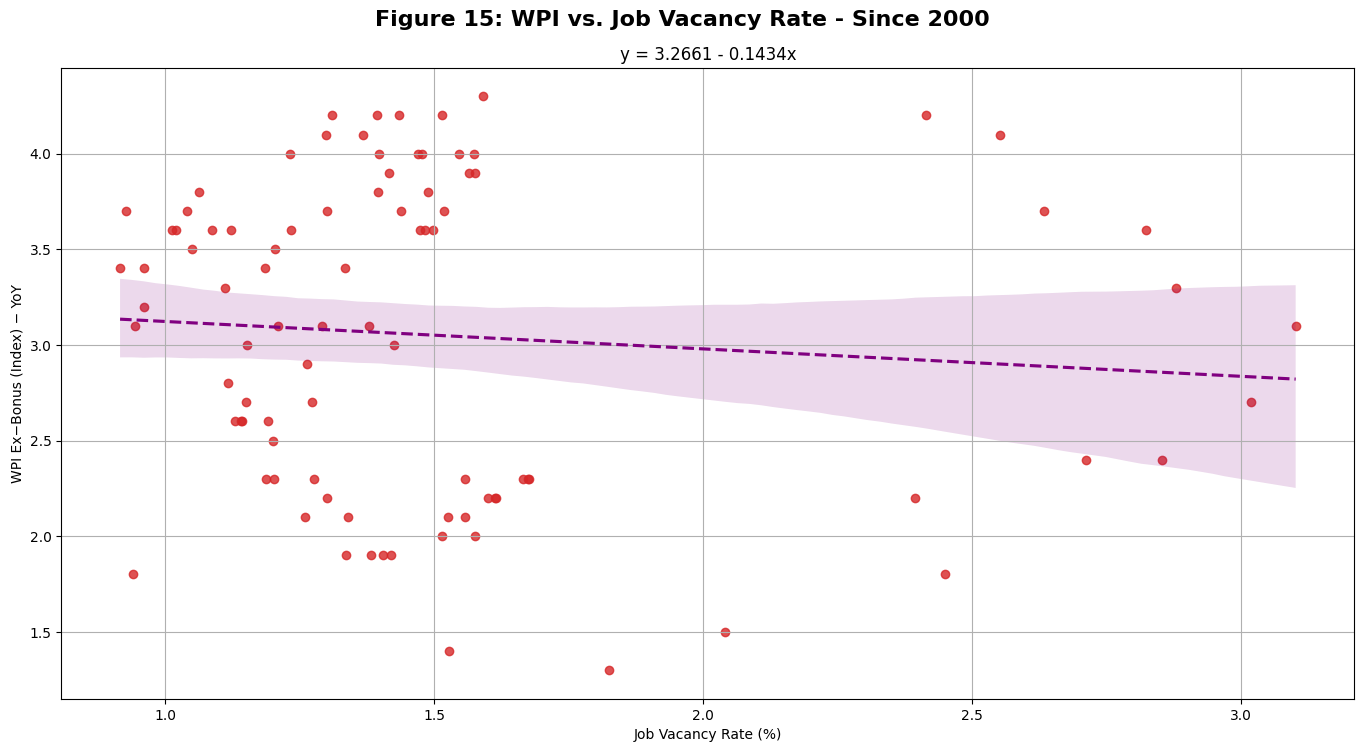

In [23]:
# Getting Series for alignment and interpolation
wpi_yoy = df_wpi_ex_bonus_yoy_sa['Percentage Change From Corresponding Quarter of Previous Year']
unemployment_rate = df_labour_sa['Unemployment rate']
underemployment_rate = df_under_sa['Underemployment rate (proportion of labour force)']
underutilisation_rate = underemployment_rate + unemployment_rate
jv_rate = df_jv_rate_sa['Jobs']

# Convert unemployment_rate to quarterly (end of October)
unemployment_rate_q = unemployment_rate.resample('QS-OCT').mean()
underutilisation_rate_q = underutilisation_rate.resample('QS-OCT').mean()

# Figure 13: WPI vs. Unemployment - Since 2000
# Align the two series and filter the data
aligned_data_unemployment = pd.DataFrame(
    {'WPI YoY': wpi_yoy, 
    'Unemployment Rate': unemployment_rate_q}).dropna()
aligned_data_unemployment = aligned_data_unemployment[aligned_data_unemployment.index >= '2000-01-01']

# Calculate linear regression
slope, intercept = np.polyfit(aligned_data_unemployment['Unemployment Rate'], aligned_data_unemployment['WPI YoY'], 1)

# Create scatter plot with regression line
fig, ax = plt.subplots(figsize=(14, 8))

# Adding a page title above the plot
fig.suptitle('Figure 13: WPI vs. Unemployment - Since 2000', fontsize=16, fontweight='bold', y=0.95)

# Scatter plot with regression line
sns.regplot(x='Unemployment Rate', y='WPI YoY', data=aligned_data_unemployment, scatter_kws={'color': 'tab:red'}, line_kws={'color': 'purple', 'linestyle': '--'}, ax=ax)

# Add title and labels
equation = f'y = {intercept:.4f} - {abs(slope):.4f}x'

# Add the line equation as the title of the graph
ax.set_title(equation, fontsize=12)
ax.set_xlabel('Unemployment Rate (%)')
ax.set_ylabel('WPI Ex−Bonus (Index) − YoY')

# Adding grid lines to the primary axis
ax.grid(True)

# Adjust layout to ensure the plot is centered and fits well within an A4 page
plt.tight_layout(pad=2.0)

# Save the current figure into the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()

# Figure 14: WPI vs. Underutilisation (UR + Underemployment) - Since 2000
# Align the series and filter the data
aligned_data_underutilisation = pd.DataFrame({'WPI YoY': wpi_yoy, 'Underutilisation Rate': underutilisation_rate_q}).dropna()
aligned_data_underutilisation = aligned_data_underutilisation[aligned_data_underutilisation.index >= '2000-01-01']

# Calculate linear regression
slope, intercept = np.polyfit(aligned_data_underutilisation['Underutilisation Rate'], aligned_data_underutilisation['WPI YoY'], 1)

# Create scatter plot with regression line
fig, ax1 = plt.subplots(figsize=(14, 8))

# Adding a page title above the plot
fig.suptitle('Figure 14: WPI vs. Underutilisation (UR + Underemployment) - Since 2000', fontsize=16, fontweight='bold', y=0.95)

# Scatter plot with regression line
sns.regplot(x='Underutilisation Rate', y='WPI YoY', data=aligned_data_underutilisation, scatter_kws={'color': 'tab:red'}, line_kws={'color': 'purple', 'linestyle': '--'}, ax=ax1)

# Add title and labels
equation = f'y = {intercept:.4f} - {abs(slope):.4f}x'

# Add the line equation as the title of the graph
ax1.set_title(equation, fontsize=12)
ax1.set_xlabel('Underutilisation Rate (%)')
ax1.set_ylabel('WPI Ex−Bonus (Index) − YoY')

# Adding grid lines to the primary axis
ax1.grid(True)

# Adjust layout to ensure the plot is centered and fits well within an A4 page
plt.tight_layout(pad=2.0)

# Save the current figure into the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()

# Figure 15: WPI vs. Job Vacancy Rate - Since 2000
# Align the series and filter the data
aligned_data_job_vacancy = pd.DataFrame({'WPI YoY': wpi_yoy, 'Job Vacancy Rate': jv_rate}).dropna()
aligned_data_job_vacancy = aligned_data_job_vacancy[aligned_data_job_vacancy.index >= '2000-01-01']

# Calculate linear regression
slope, intercept = np.polyfit(aligned_data_job_vacancy['Job Vacancy Rate'], aligned_data_job_vacancy['WPI YoY'], 1)

# Create scatter plot with regression line
fig, ax2 = plt.subplots(figsize=(14, 8))

# Adding a page title above the plot
fig.suptitle('Figure 15: WPI vs. Job Vacancy Rate - Since 2000', fontsize=16, fontweight='bold', y=0.95)

# Scatter plot with regression line
sns.regplot(x='Job Vacancy Rate', y='WPI YoY', data=aligned_data_job_vacancy, scatter_kws={'color': 'tab:red'}, line_kws={'color': 'purple', 'linestyle': '--'}, ax=ax2)

# Add title and labels
equation = f'y = {intercept:.4f} - {abs(slope):.4f}x'

# Add the line equation as the title of the graph
ax2.set_title(equation, fontsize=12)
ax2.set_xlabel('Job Vacancy Rate (%)')
ax2.set_ylabel('WPI Ex−Bonus (Index) − YoY')

# Adding grid lines to the primary axis
ax2.grid(True)

# Adjust layout to ensure the plot is centered and fits well within an A4 page
plt.tight_layout(pad=2.0)

# Save the current figure into the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()


In [46]:
# Figure 16: Monthly Hours Worked
fig, ax1 = plt.subplots(figsize=(14, 8))

# Calculating series for plotting
hours_worked_yoy = percent_change(df_hour_worked_sa['Monthly hours worked in all jobs'])

# Add page title
fig.suptitle('Figure 16: Monthly Hours Worked', fontsize=16, fontweight='bold', y=0.95)

# Plot lines
ax1.bar(hours_worked_yoy.index, hours_worked_yoy, 25, label='YoY', color='tab:blue')

# Create a second y-axis for total unemployed
ax2 = ax1.twinx()
ax2.plot(df_hour_worked_sa['Monthly hours worked in all jobs'].index, df_hour_worked_sa['Monthly hours worked in all jobs'], label='Monthly Hours Worked (RHS)', color='tab:red', linestyle='-')


# Set labels for x and y axes
ax1.set_xlabel('Date')
ax1.set_ylabel('(%)')

ax2.set_ylabel('(Millions)')

# Set title for the axes
ax1.set_title('Monthly Hours Worked − YoY vs. Total')

# Format x-axis to show month/year
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

# Set x-axis limits
ax1.set_xlim([datetime(2009, 10, 1), hours_worked_yoy.index.max()])

# Add grid to the main axis
ax1.grid(True)

# Rotate x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=90)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout to ensure the plot is centered and well-fitted on the A4 page
plt.tight_layout(pad=2.0)

# Save the current figure to the PDF
pdf.savefig(fig, bbox_inches='tight')

# Close the plot
plt.close()

### Doing

In [24]:
pdf.close()
